# OASIS-1 Data Exploration Notebook

## Purpose
This notebook explores and visualizes OASIS-1 brain MRI data step by step.

## What You'll Learn
1. How to find and load subject folders from multiple disc locations
2. How to load metadata from Excel files using pandas
3. How to load brain MRI scans using nibabel
4. How to visualize 3D brain data as 2D slices
5. How to explore and analyze metadata statistics

## Prerequisites
Make sure you have installed the required libraries:
```bash
pip install nibabel pandas matplotlib numpy seaborn openpyxl jupyter
```

## How to Run This Notebook
1. Open terminal/command prompt in this project directory
2. Type: `jupyter notebook`
3. Your browser will open - click on `explore_oasis_data.ipynb`
4. Run cells one by one using Shift+Enter, or run all using Cell > Run All


## Step 0: Install Required Libraries (Run This First!)

If you get "ModuleNotFoundError", run this cell first to install all required packages:

```python
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn nibabel openpyxl
```

After running this, restart the kernel (Kernel > Restart) and then continue with the notebook.

## Step 1: Import Required Libraries

We need several Python libraries to work with neuroimaging data:
- **os**: For working with file paths and directories (built-in)
- **glob**: For finding files matching patterns (built-in)
- **pandas**: For working with Excel/CSV data (metadata)
- **numpy**: For numerical operations and arrays
- **matplotlib**: For creating plots and visualizations
- **seaborn**: For prettier statistical plots
- **nibabel**: For loading neuroimaging files (.hdr/.img, .nii format)
- **openpyxl**: For reading Excel files


In [2]:
# Install required packages (run this if you get ModuleNotFoundError)
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn nibabel openpyxl


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached nibabel-5.3.3-py3-none-any.whl.metadata (9.1 kB)
  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.0 MB 2.4 MB/s eta 0:00:05
   --- ------------------------------------ 1.0/11.0 MB 3.1 MB/s eta 0:00:04
   ----- ---------------------------------- 1.6/11.0 MB 2.8 MB/s eta 0:00:04
   -------- ------------------------------- 2.4/11.0 MB 2.9 MB/s eta 0:00:04
   --------- ------


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Standard library imports (built into Python)
import os  # For working with file paths and directories
import glob  # For finding files matching patterns

# Third-party libraries (install with: pip install <library>)
import pandas as pd  # For working with Excel/CSV data
import numpy as np  # For numerical operations and arrays
import matplotlib.pyplot as plt  # For creating plots
import seaborn as sns  # For prettier statistical plots
import nibabel as nib  # For loading neuroimaging files

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("All libraries imported successfully")


All libraries imported successfully


## Step 2: Find All Subject Folders

**Why this step matters**: OASIS-1 data is split across multiple disc folders (disc1, disc12, etc.). We need to find all subject folders to work with the complete dataset.

**What we're doing**: 
- Checking both disc1 and disc12 directories
- Collecting all subject folder paths
- Counting how many subjects we have


In [4]:
# Define the base data directory
# Note: Adjust this path if your data folder has a different name
data_dir = "Data"

# Check if directory exists
if not os.path.exists(data_dir):
    print(f"Error: {data_dir} folder not found!")
    print("Make sure you're running this notebook from the project root directory.")
else:
    print(f"Found data directory: {data_dir}")

# Find all subject folders in disc1
disc1_path = os.path.join(data_dir, "oasis_cross-sectional_disc1", "disc1")
disc1_subjects = []
if os.path.exists(disc1_path):
    # Get all folders in disc1 (each folder represents one subject)
    disc1_subjects = [os.path.join(disc1_path, d) 
                      for d in os.listdir(disc1_path) 
                      if os.path.isdir(os.path.join(disc1_path, d))]
    print(f"Found {len(disc1_subjects)} subjects in disc1")

# Find all subject folders in disc12
disc12_path = os.path.join(data_dir, "oasis_cross-sectional_disc12", "disc12")
disc12_subjects = []
if os.path.exists(disc12_path):
    disc12_subjects = [os.path.join(disc12_path, d) 
                       for d in os.listdir(disc12_path) 
                       if os.path.isdir(os.path.join(disc12_path, d))]
    print(f"Found {len(disc12_subjects)} subjects in disc12")

# Combine all subjects
all_subject_folders = disc1_subjects + disc12_subjects
total_subjects = len(all_subject_folders)

print(f"\nTotal subjects found: {total_subjects}")
print(f"  - Disc1: {len(disc1_subjects)} subjects")
print(f"  - Disc12: {len(disc12_subjects)} subjects")


Found data directory: Data
Found 39 subjects in disc1
Found 36 subjects in disc12

Total subjects found: 75
  - Disc1: 39 subjects
  - Disc12: 36 subjects


## Step 3: Extract Subject IDs

**Why this step matters**: Subject folders are named like "OAS1_0001_MR1", but we need just the ID part ("OAS1_0001") to match with the Excel metadata file.

**What we're doing**: Creating a function to extract the subject ID from folder names.


In [5]:
def extract_subject_id(folder_path):
    """
    Extract subject ID from folder path.
    
    Example:
    Input:  "Data/oasis_cross-sectional_disc1/disc1/OAS1_0001_MR1"
    Output: "OAS1_0001"
    """
    # Get just the folder name (last part of path)
    folder_name = os.path.basename(folder_path)
    # Remove "_MR1" part to get just the ID
    subject_id = folder_name.replace("_MR1", "")
    return subject_id

# Extract IDs from all subject folders
subject_ids = [extract_subject_id(folder) for folder in all_subject_folders]

print(f"Extracted {len(subject_ids)} subject IDs")
print(f"Example IDs: {subject_ids[:5]}")


Extracted 75 subject IDs
Example IDs: ['OAS1_0001', 'OAS1_0002', 'OAS1_0003', 'OAS1_0004', 'OAS1_0005']


## Step 4: Load Metadata from Excel File

**Why this step matters**: The Excel file contains important information about each subject: age, gender, diagnosis (Demented/Nondemented), MMSE scores, etc. This metadata is essential for our analysis.

**What we're doing**: 
- Loading the Excel file into a pandas DataFrame (like a spreadsheet in Python)
- Examining the structure and columns
- Understanding what information is available


In [6]:
# Path to Excel file
excel_path = os.path.join(data_dir, "oasis_cross-sectional.xlsx")

# Check if file exists
if not os.path.exists(excel_path):
    print(f"Error: {excel_path} not found!")
else:
    # Load Excel file into pandas DataFrame
    # DataFrame is like an Excel spreadsheet but in Python
    print("Loading metadata from Excel file...")
    metadata_df = pd.read_excel(excel_path)
    
    print(f"Loaded metadata for {len(metadata_df)} subjects")
    print(f"Columns: {list(metadata_df.columns)}")
    print("\nFirst 5 rows:")
    print(metadata_df.head())


Loading metadata from Excel file...
Loaded metadata for 436 subjects
Columns: ['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Delay']

First 5 rows:
              ID M/F Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF  \
0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743  1.306   
1  OAS1_0002_MR1   F    R   55   4.0  1.0  29.0  0.0  1147  0.810  1.531   
2  OAS1_0003_MR1   F    R   73   4.0  3.0  27.0  0.5  1454  0.708  1.207   
3  OAS1_0004_MR1   M    R   28   NaN  NaN   NaN  NaN  1588  0.803  1.105   
4  OAS1_0005_MR1   M    R   18   NaN  NaN   NaN  NaN  1737  0.848  1.010   

   Delay  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN  


## Step 5: Filter Metadata for Subjects We Have Scans For

**Why this step matters**: The Excel file contains metadata for all 416 subjects in OASIS-1, but we only have brain scans for a subset (75 subjects from disc1 and disc12). We need to filter the metadata to only include subjects where we have scans.

**What we're doing**: Matching subject IDs from our folders with IDs in the Excel file.


In [7]:
# Find the ID column in the Excel file (column name might vary)
id_column = None
for col in metadata_df.columns:
    if 'ID' in str(col).upper() or 'id' in str(col).lower():
        id_column = col
        break

# If not found, try common variations
if id_column is None:
    possible_cols = ['ID', 'Id', 'id', 'Subject', 'SUBJECT']
    for col in possible_cols:
        if col in metadata_df.columns:
            id_column = col
            break

if id_column is None:
    print("Warning: Could not find ID column. Using first column.")
    id_column = metadata_df.columns[0]

print(f"Using column '{id_column}' for subject IDs")

# Filter: keep only rows where we have the scan
available_metadata = metadata_df[metadata_df[id_column].isin(subject_ids)].copy()

# If no matches, try alternative matching (handle different ID formats)
if len(available_metadata) == 0:
    print("Trying alternative ID matching...")
    metadata_df['extracted_id'] = metadata_df[id_column].astype(str).str.replace('_MR1', '')
    available_metadata = metadata_df[metadata_df['extracted_id'].isin(subject_ids)].copy()

print(f"Found metadata for {len(available_metadata)} subjects with scans")


Using column 'ID' for subject IDs
Trying alternative ID matching...
Found metadata for 75 subjects with scans


## Step 6: Explore Metadata Statistics

**Why this step matters**: Understanding the distribution of key variables (diagnosis, age, MMSE scores) helps us understand our dataset and identify any imbalances or patterns.

**What we're doing**: 
- Counting subjects by diagnosis (Demented vs Nondemented)
- Calculating age statistics
- Analyzing MMSE score distribution
- Creating visualizations


In [8]:
# Find diagnosis/group column
diagnosis_col = None
for col in available_metadata.columns:
    col_lower = str(col).lower()
    if 'group' in col_lower or 'diagnosis' in col_lower or 'demented' in col_lower:
        diagnosis_col = col
        break

if diagnosis_col:
    print(f"Diagnosis distribution (column: '{diagnosis_col}'):")
    diagnosis_counts = available_metadata[diagnosis_col].value_counts()
    print(diagnosis_counts)
    print()
    
    # Create bar plot
    plt.figure(figsize=(8, 6))
    diagnosis_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
    plt.title('Number of Subjects by Diagnosis', fontsize=14, fontweight='bold')
    plt.xlabel('Diagnosis', fontsize=12)
    plt.ylabel('Number of Subjects', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('diagnosis_distribution.png', dpi=150)
    print("Saved plot: diagnosis_distribution.png")
    plt.show()
else:
    print("Diagnosis column not found")


Diagnosis column not found


Age statistics (column: 'Age'):
  Mean age: 56.3 years
  Age range: 18 - 92 years

Saved plot: age_distribution.png


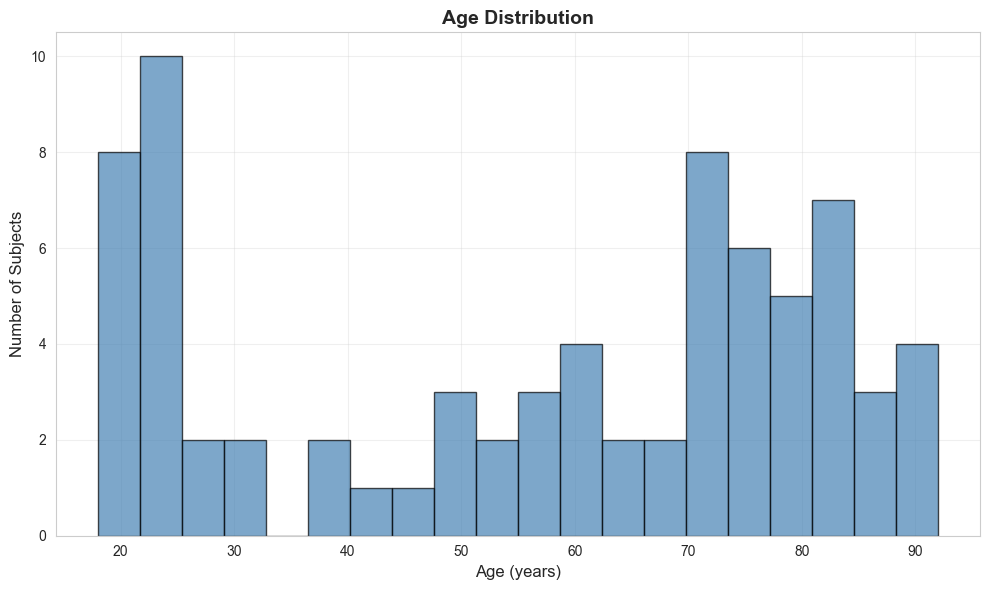

In [9]:
# Age statistics
age_col = None
for col in available_metadata.columns:
    if 'age' in str(col).lower():
        age_col = col
        break

if age_col:
    print(f"Age statistics (column: '{age_col}'):")
    print(f"  Mean age: {available_metadata[age_col].mean():.1f} years")
    print(f"  Age range: {available_metadata[age_col].min():.0f} - {available_metadata[age_col].max():.0f} years")
    print()
    
    # Create histogram
    plt.figure(figsize=(10, 6))
    plt.hist(available_metadata[age_col], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
    plt.xlabel('Age (years)', fontsize=12)
    plt.ylabel('Number of Subjects', fontsize=12)
    plt.title('Age Distribution', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('age_distribution.png', dpi=150)
    print("Saved plot: age_distribution.png")
    plt.show()
else:
    print("Age column not found")


MMSE score statistics (column: 'MMSE'):
  Mean MMSE: 27.4
  Range: 17 - 30

Saved plot: mmse_distribution.png


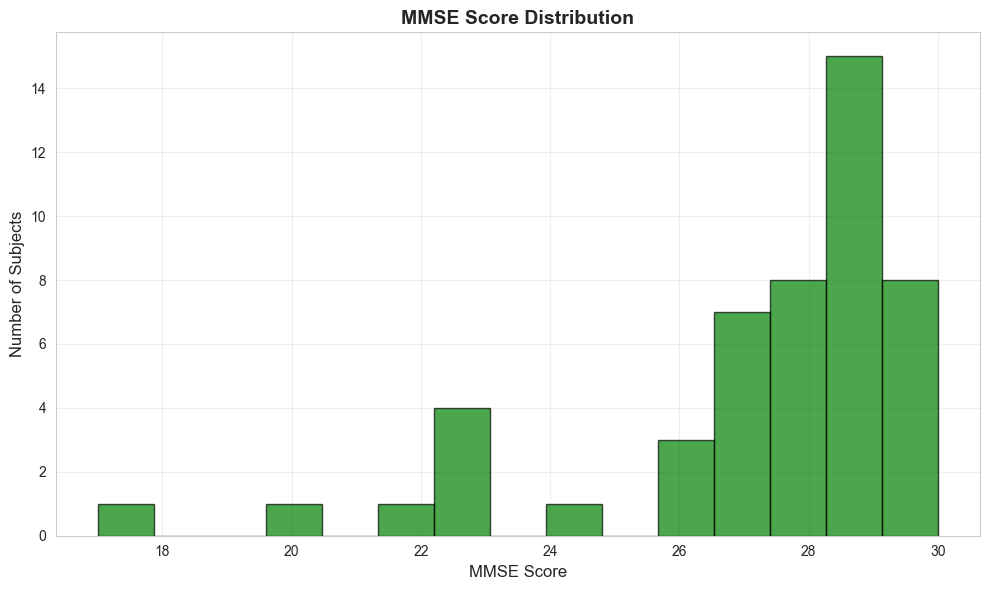

In [10]:
# MMSE score statistics
mmse_col = None
for col in available_metadata.columns:
    if 'mmse' in str(col).lower():
        mmse_col = col
        break

if mmse_col:
    print(f"MMSE score statistics (column: '{mmse_col}'):")
    print(f"  Mean MMSE: {available_metadata[mmse_col].mean():.1f}")
    print(f"  Range: {available_metadata[mmse_col].min():.0f} - {available_metadata[mmse_col].max():.0f}")
    print()
    
    # Create histogram
    plt.figure(figsize=(10, 6))
    plt.hist(available_metadata[mmse_col], bins=15, edgecolor='black', alpha=0.7, color='green')
    plt.xlabel('MMSE Score', fontsize=12)
    plt.ylabel('Number of Subjects', fontsize=12)
    plt.title('MMSE Score Distribution', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('mmse_distribution.png', dpi=150)
    print("Saved plot: mmse_distribution.png")
    plt.show()
else:
    print("MMSE column not found")


## Step 7: Load and Visualize Brain MRI Scans

**Why this step matters**: Brain MRI scans are 3D images stored as .hdr (header) and .img (image data) files. We need to load them using nibabel and visualize them as 2D slices since we can't display 3D directly.

**What we're doing**:
- Loading one brain scan as an example
- Extracting the 3D image data
- Visualizing three views: axial (top-down), sagittal (side), coronal (front)
- Showing multiple slices to understand the 3D structure


In [15]:
# Pick the first subject folder as an example
if len(all_subject_folders) > 0:
    example_folder = all_subject_folders[0]
    subject_id_example = extract_subject_id(example_folder)
    
    print(f"Loading brain scan from: {subject_id_example}")
    print(f"Folder: {example_folder}")
    
    # Find .hdr file - they are in the RAW subdirectory
    # Check RAW subdirectory first (where files actually are)
    raw_folder = os.path.join(example_folder, "RAW")
    if os.path.exists(raw_folder):
        hdr_files = glob.glob(os.path.join(raw_folder, "*.hdr"))
        print(f"Looking in RAW subdirectory...")
    else:
        # Fallback: try directly in subject folder
        hdr_files = glob.glob(os.path.join(example_folder, "*.hdr"))
        print(f"Looking in subject folder...")
    
    if len(hdr_files) == 0:
        print("No .hdr file found!")
        print(f"Checked: {raw_folder if os.path.exists(raw_folder) else example_folder}")
    else:
        hdr_file = hdr_files[0]  # Take the first one
        print(f"Found scan file: {os.path.basename(hdr_file)}")
        
        try:
            # Load the brain scan using nibabel
            # This reads both .hdr and .img files automatically
            print("Loading scan...")
            brain_img = nib.load(hdr_file)
            
            # Get the actual image data (3D array)
            # Shape is (x, y, z) representing 3D brain volume
            brain_data = brain_img.get_fdata()
            
            print(f"Scan loaded successfully!")
            print(f"  Image shape: {brain_data.shape}")
            print(f"  Data type: {brain_data.dtype}")
            print(f"  Value range: {brain_data.min():.1f} to {brain_data.max():.1f}")
            
        except Exception as e:
            print(f"Error loading scan: {e}")
            print("Make sure nibabel is installed: pip install nibabel")
else:
    print("No subject folders found!")


Loading brain scan from: OAS1_0001
Folder: Data\oasis_cross-sectional_disc1\disc1\OAS1_0001_MR1
Looking in RAW subdirectory...
Found scan file: OAS1_0001_MR1_mpr-1_anon.hdr
Loading scan...
Scan loaded successfully!
  Image shape: (256, 256, 128, 1)
  Data type: float64
  Value range: 0.0 to 4095.0


## Step 8: Visualize Brain Scan - Three Views

**What we're visualizing**: Three orthogonal views of the brain:
- **Axial**: Top-down view (horizontal slice)
- **Sagittal**: Side view (vertical slice from left to right)
- **Coronal**: Front view (vertical slice from front to back)

These views help us understand the 3D structure of the brain.


Saved brain scan visualization: brain_scan_example.png


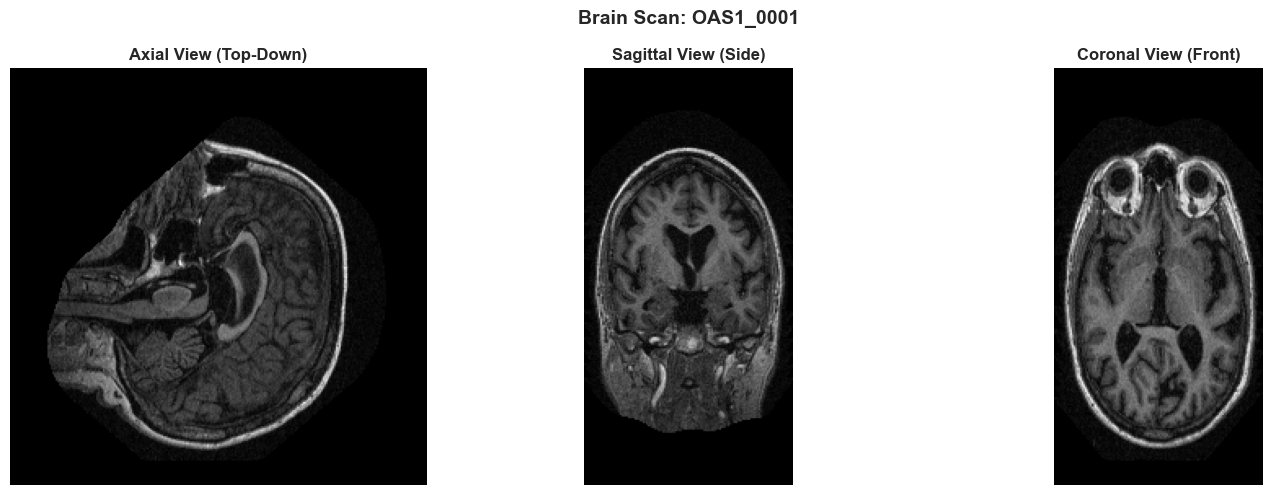

In [16]:
# Get the middle slice in each dimension
x_mid = brain_data.shape[0] // 2
y_mid = brain_data.shape[1] // 2
z_mid = brain_data.shape[2] // 2

# Create a figure with 3 subplots (one for each view)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial slice (top-down view, looking from above)
# This is a horizontal cut through the brain
axes[0].imshow(brain_data[:, :, z_mid], cmap='gray', origin='lower')
axes[0].set_title('Axial View (Top-Down)', fontsize=12, fontweight='bold')
axes[0].axis('off')  # Remove axes for cleaner look

# Sagittal slice (side view, looking from the side)
# This is a vertical cut from left to right
axes[1].imshow(brain_data[x_mid, :, :], cmap='gray', origin='lower')
axes[1].set_title('Sagittal View (Side)', fontsize=12, fontweight='bold')
axes[1].axis('off')

# Coronal slice (front view, looking from front)
# This is a vertical cut from front to back
axes[2].imshow(brain_data[:, y_mid, :], cmap='gray', origin='lower')
axes[2].set_title('Coronal View (Front)', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.suptitle(f'Brain Scan: {subject_id_example}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('brain_scan_example.png', dpi=150, bbox_inches='tight')
print("Saved brain scan visualization: brain_scan_example.png")
plt.show()


## Step 9: Visualize Multiple Slices

**Why this helps**: Showing multiple slices at different depths helps us understand how the brain structure changes throughout the 3D volume. This is useful for understanding the anatomy.


Saved multiple slices: brain_slices_example.png


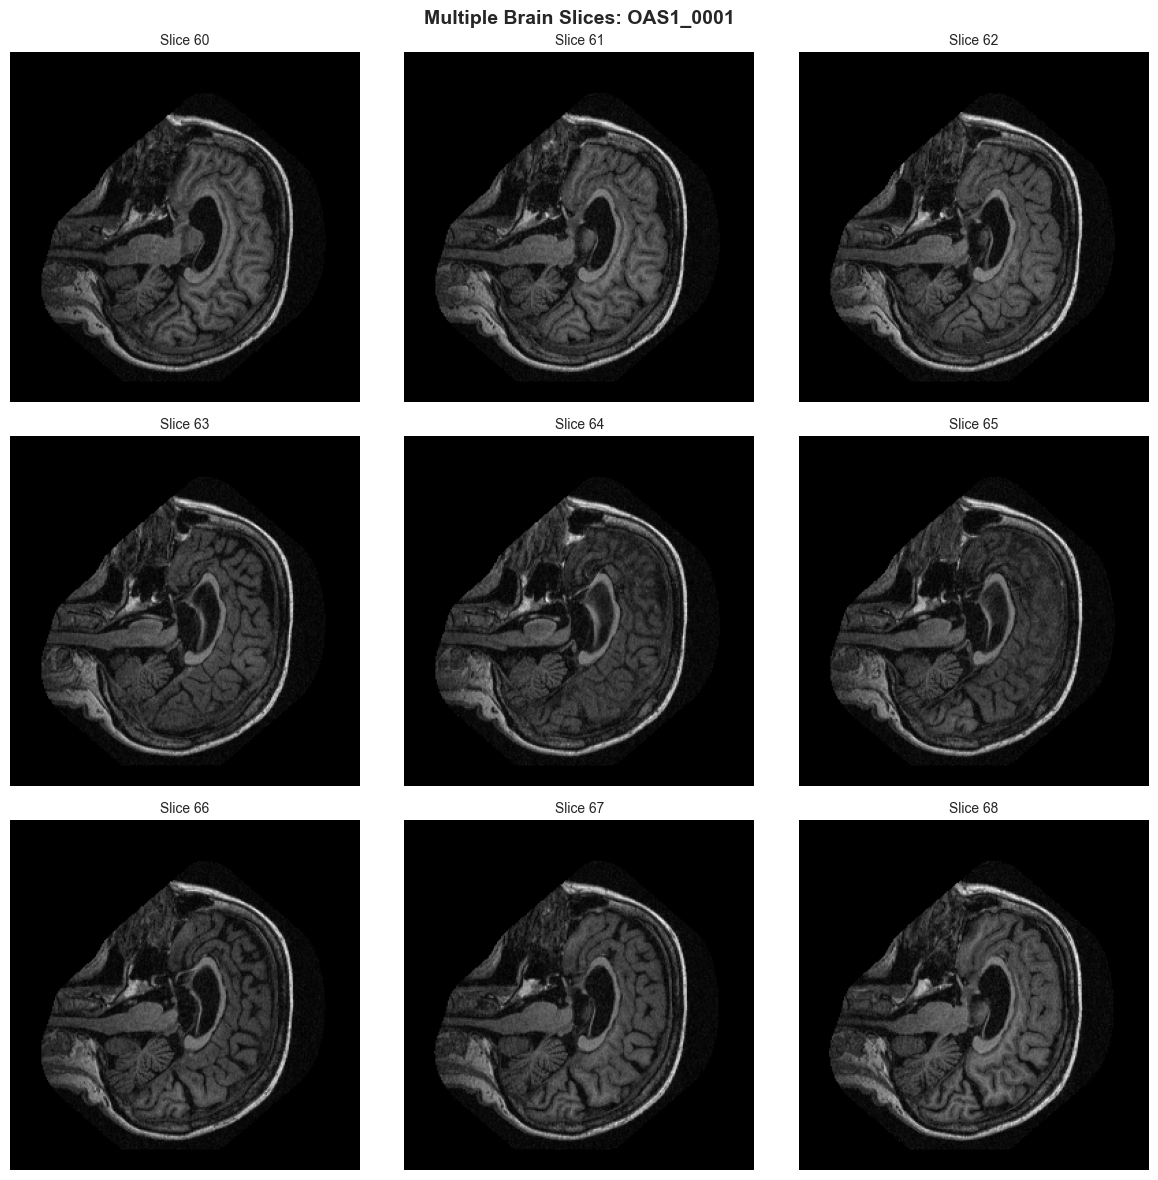

In [17]:
# Show 9 slices from the middle of the brain (axial view)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

# Get 9 slices around the middle
start_slice = z_mid - 4
end_slice = z_mid + 5

for i, z in enumerate(range(start_slice, end_slice)):
    if z >= 0 and z < brain_data.shape[2]:
        axes[i].imshow(brain_data[:, :, z], cmap='gray', origin='lower')
        axes[i].set_title(f'Slice {z}', fontsize=10)
        axes[i].axis('off')

plt.suptitle(f'Multiple Brain Slices: {subject_id_example}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('brain_slices_example.png', dpi=150, bbox_inches='tight')
print("Saved multiple slices: brain_slices_example.png")
plt.show()


## Summary

**What we accomplished**:
1. Found and counted all subject folders from disc1 and disc12
2. Loaded metadata from Excel file
3. Filtered metadata to match subjects with available scans
4. Explored key statistics (diagnosis, age, MMSE scores)
5. Loaded and visualized brain MRI scans in multiple views

**Generated files**:
- diagnosis_distribution.png
- age_distribution.png
- mmse_distribution.png
- brain_scan_example.png
- brain_slices_example.png

**Next steps**:
- Compare brain scans between Demented and Nondemented groups
- Extract features from brain scans
- Build a machine learning classifier
